In [289]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy as cy
import matplotlib.path as mpath

In [26]:
class TaiESM():
    def __init__(self, data):
        self.data = xr.open_dataset(data)
        
        self.LON = self.getVar("lon")
        self.LAT = self.getVar("lat")
        self.LON2, self.LAT2 = np.meshgrid(self.LON, self.LAT)
        self.LEV_PRE = self.getLevPre()

    
    def getVar(self, var):
        if type(var) == str:
            return self.data[var].to_numpy()
        elif type(var) == list or type(var) == numpy.ndarray:
            retVal = []
            for i in range(len(var)):
                retVal.append(self.data[var[i]].to_numpy())
            return retVal
        
    def getLevPre(self):
        PS_tile = np.tile(self.getVar("PS"), (30, 1, 1))
        hybm_tile = np.tile(self.getVar("hybm"), (192, 288, 1)).swapaxes(0, 2).swapaxes(1, 2)
        PRS_lev = np.tile(self.getVar("P0")*self.getVar("hybm"), (192, 288, 1)).swapaxes(0, 2).swapaxes(1, 2) + PS_tile * hybm_tile
        return PRS_lev

In [199]:
ds_ctl = TaiESM("/home/Aaron/Workshop-of-Earth-System-Model/hw3/data/f09.F2000.Aaron_10years/atm/hist/f09.F2000.Aaron_10years.cam.h0.2001-01.nc")
ds_ice = TaiESM("/home/Aaron/Workshop-of-Earth-System-Model/hw3/data/f09.F2000.Aaron_week4/atm/hist/f09.F2000.Aaron_week4.cam.h0.2000-01.nc")

ds2_ctl = xr.open_dataset("/home/Aaron/Workshop-of-Earth-System-Model/hw3/data/f09.F2000.Aaron_10years/atm/hist/f09.F2000.Aaron_10years.cam.h1.2001-01.nc")
SST_ctl = np.asarray(ds2_ctl["SST"])[0]
SIC_ctl = np.asarray(ds2_ctl["ICEFRAC"])[0]
LHFLX_ctl = np.asarray(ds2_ctl["LHFLX"])[0]
SHFLX_ctl = np.asarray(ds2_ctl["SHFLX"])[0]
PSL_ctl = np.asarray(ds2_ctl["PSL"])[0]


SST_ice = np.asarray(ds_ice.getVar("SST"))[0]
SIC_ice = np.asarray(ds_ice.getVar("ICEFRAC"))[0]
LHFLX_ice = np.asarray(ds_ice.getVar("LHFLX"))[0]
SHFLX_ice = np.asarray(ds_ice.getVar("SHFLX"))[0]
PSL_ice = np.asarray(ds_ice.getVar("PSL"))[0]


In [286]:
def polarCentral_set_latlim(lat_lims, ax):
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], ccrs.PlateCarree())
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)

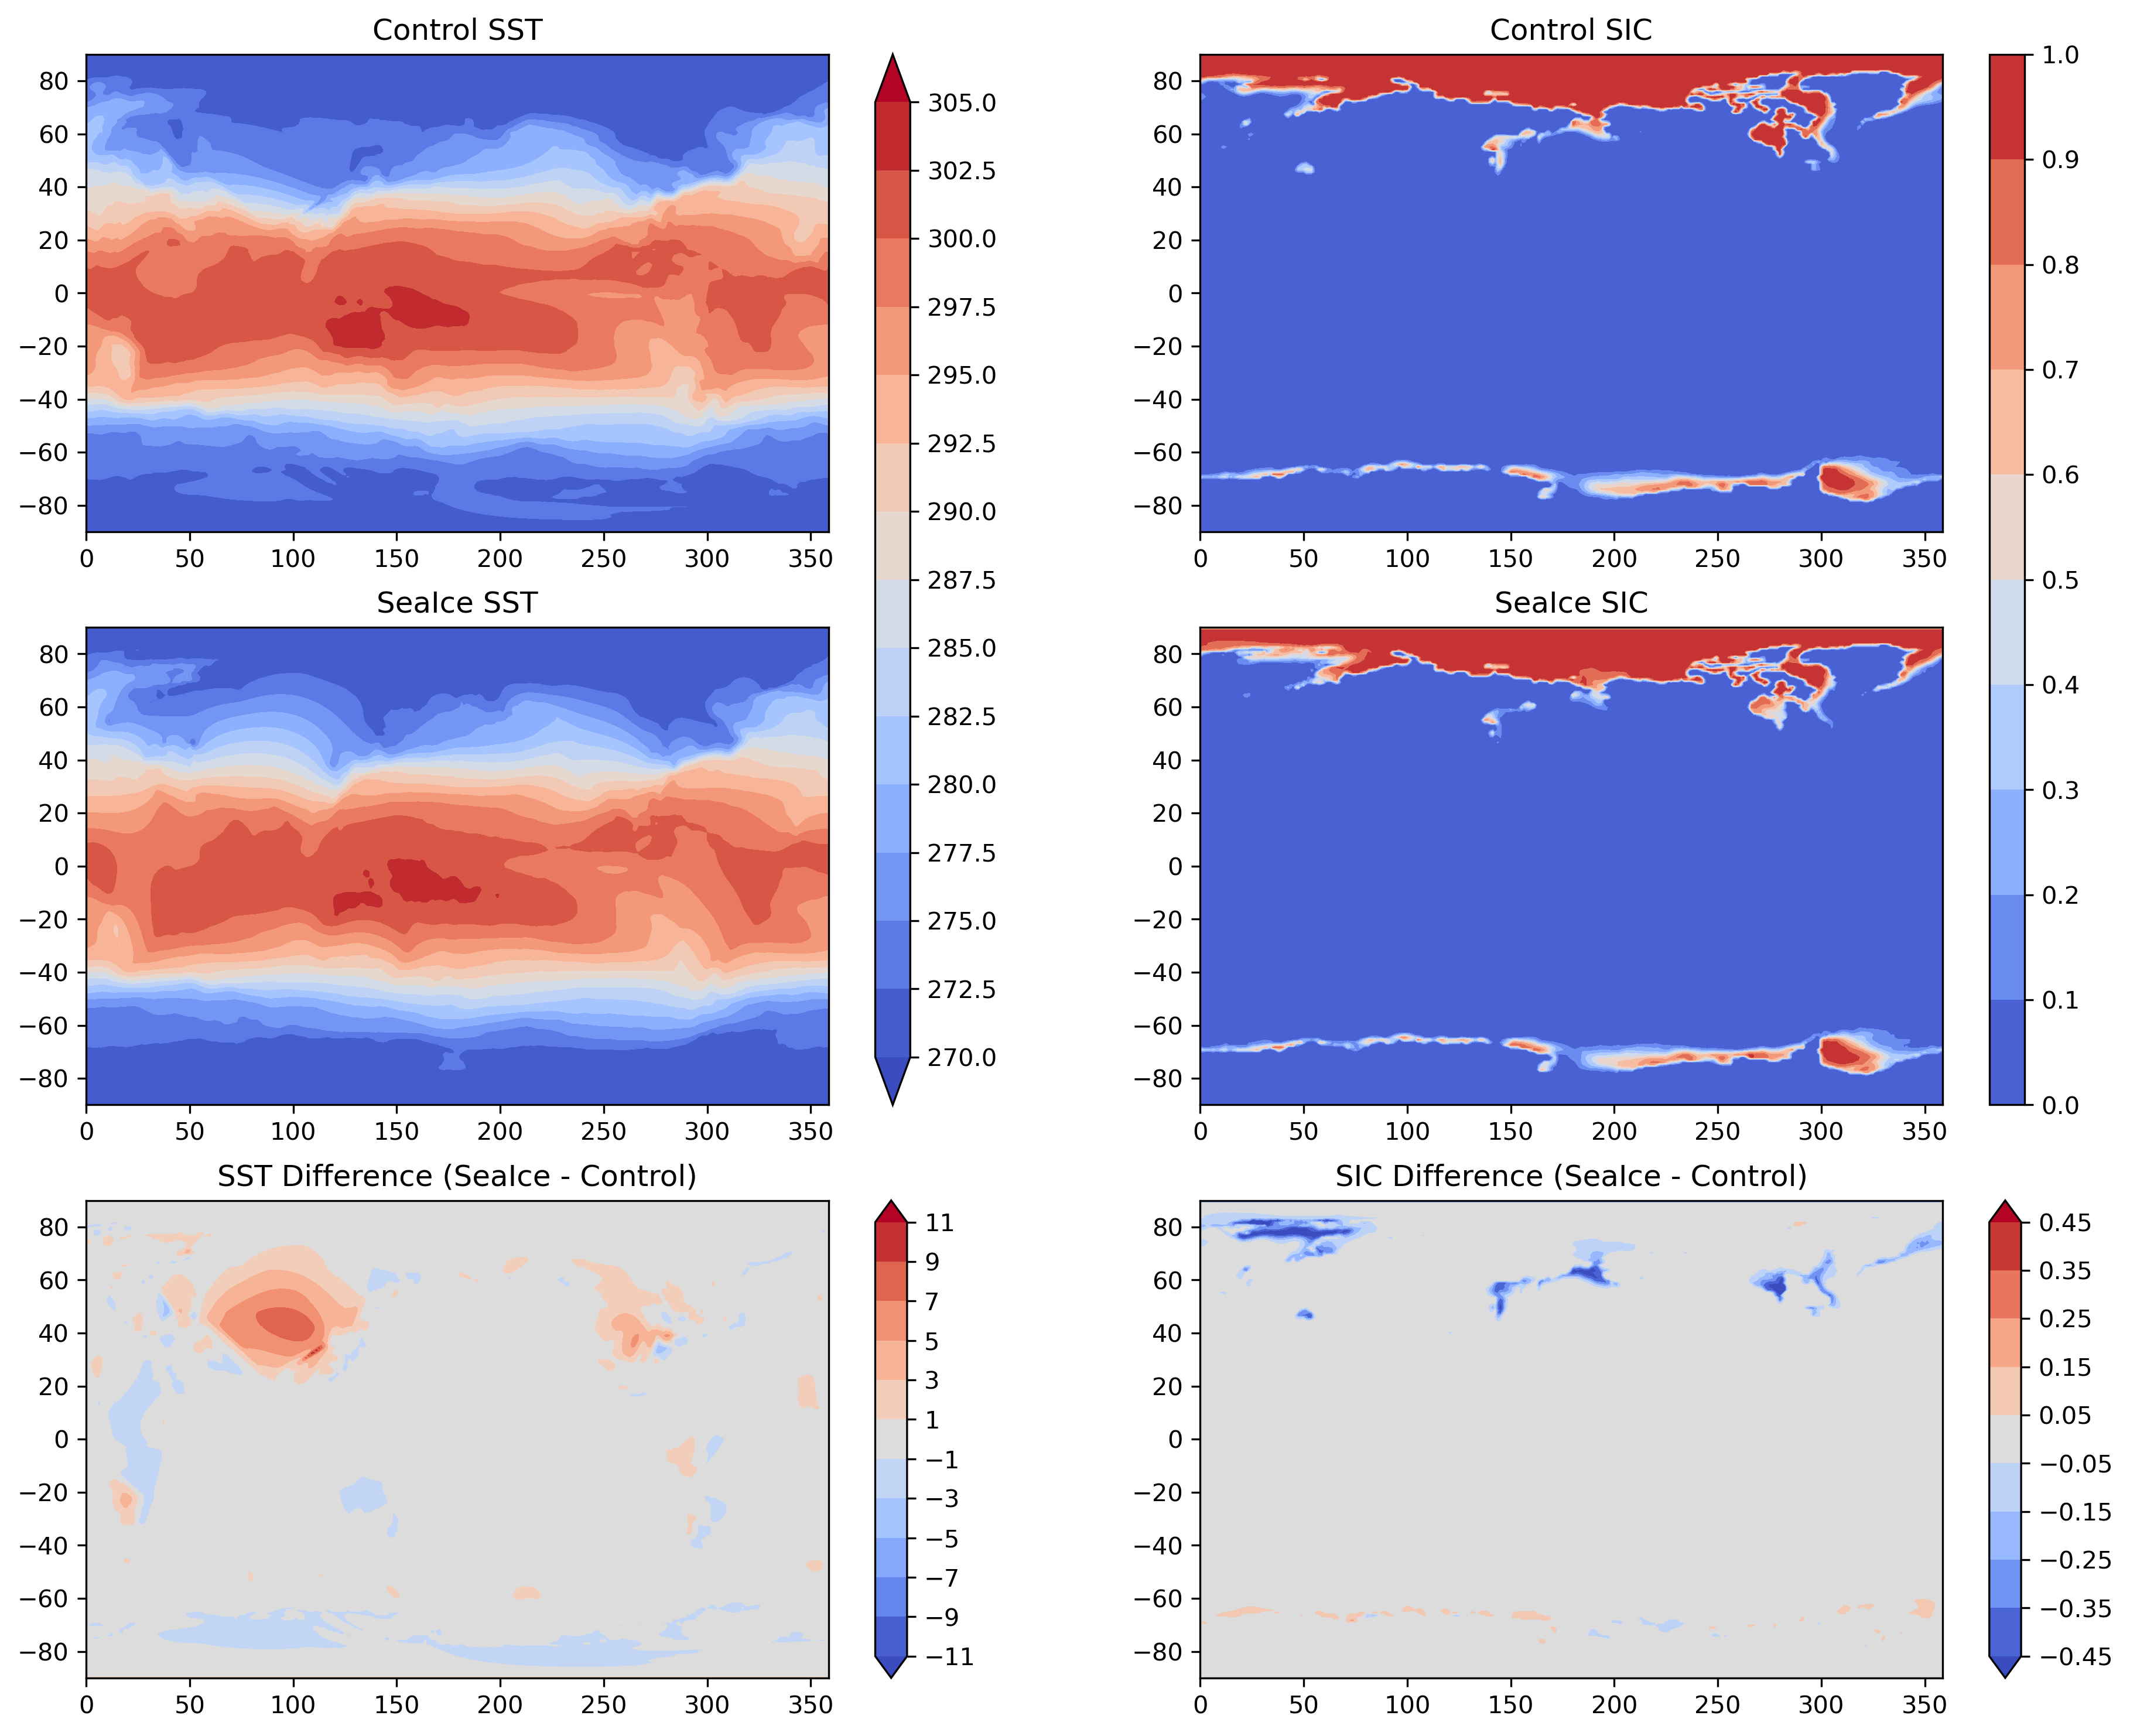

In [296]:
left_SST, right_SST, split_SST = 270, 305, 15
left_SIC, right_SIC, split_SIC = 0, 1, 11

left_SST_diff, right_SST_diff, split_SST_diff = -11, 11, 12
left_SIC_diff, right_SIC_diff, split_SIC_diff = -0.45, 0.45, 10

CMAP = cm.coolwarm


fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12), dpi=300)
cs1 = ax[0, 0].contourf(ds_ctl.LON2, ds_ctl.LAT2, SST_ctl, extend='both', levels=np.linspace(left_SST, right_SST, split_SST), cmap=CMAP)
cs12 = ax[1, 0].contourf(ds_ice.LON2, ds_ice.LAT2, SST_ice, extend='both', levels=np.linspace(left_SST, right_SST, split_SST), cmap=CMAP)
fig.colorbar(cs1, ax=ax[0:2, 0], ticks=np.linspace(left_SST, right_SST, split_SST), aspect=30)

ax[0, 0].set_title("Control SST")
ax[0, 1].set_title("Control SIC")


cs2 = ax[0, 1].contourf(ds_ctl.LON2, ds_ctl.LAT2, SIC_ctl, levels=np.linspace(left_SIC, right_SIC, split_SIC), cmap=CMAP)
cs22 = ax[1, 1].contourf(ds_ice.LON2, ds_ice.LAT2, SIC_ice, levels=np.linspace(left_SIC, right_SIC, split_SIC), cmap=CMAP)
fig.colorbar(cs2, ax=ax[0:2, 1], ticks=np.linspace(left_SIC, right_SIC, split_SIC), aspect=30)

ax[1, 0].set_title("SeaIce SST")
ax[1, 1].set_title("SeaIce SIC")



cs13 = ax[2, 0].contourf(ds_ctl.LON2, ds_ctl.LAT2, SST_ice-SST_ctl, extend='both', levels=np.linspace(left_SST_diff, right_SST_diff, split_SST_diff), cmap=CMAP)
fig.colorbar(cs13, ticks=np.linspace(left_SST_diff, right_SST_diff, split_SST_diff), aspect=15)

ax[2, 0].set_title("SST Difference (SeaIce - Control)")



cs23 = ax[2, 1].contourf(ds_ctl.LON2, ds_ctl.LAT2, SIC_ice-SIC_ctl, extend='both', levels=np.linspace(left_SIC_diff, right_SIC_diff, split_SIC_diff), cmap=CMAP)
fig.colorbar(cs23, ticks=np.linspace(left_SIC_diff, right_SIC_diff, split_SIC_diff), aspect=15)

ax[2, 1].set_title("SIC Difference (SeaIce - Control)")

plt.savefig("../graphs/SSTSIC.png", dpi=300)

plt.show()

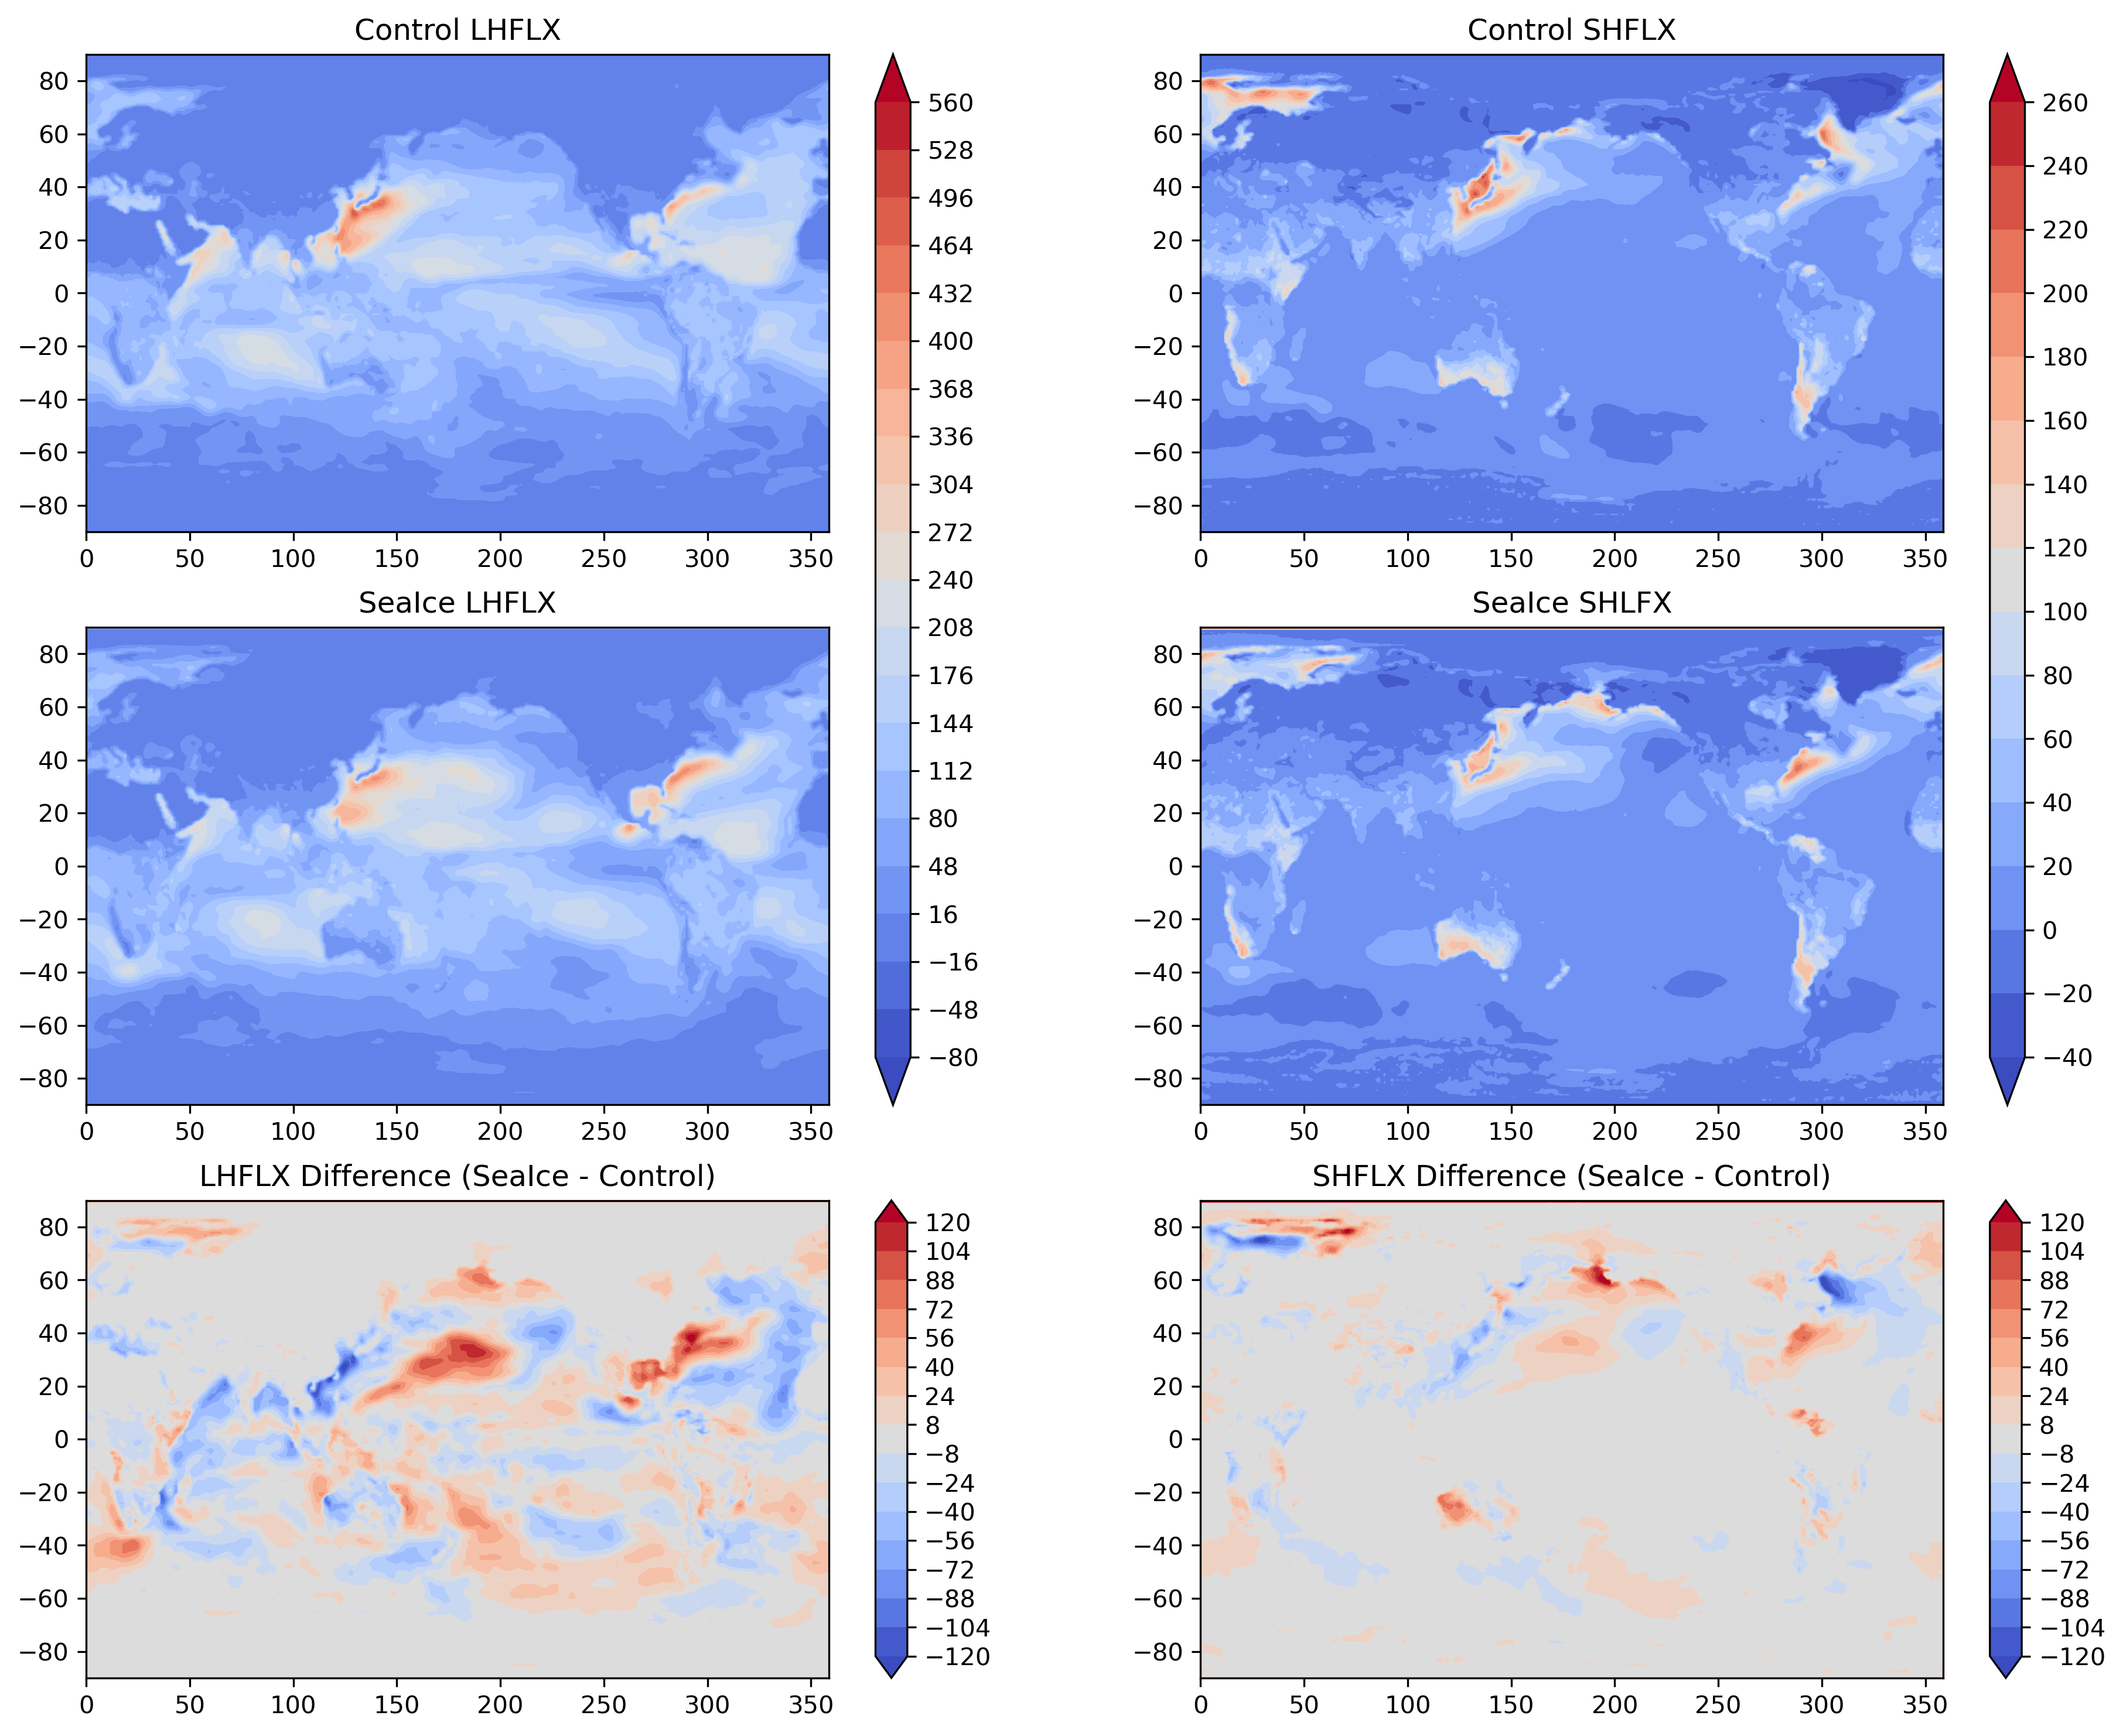

In [301]:
left_LHFLX, right_LHFLX, split_LHFLX = -80, 560, 21
left_SHFLX, right_SHFLX, split_SHFLX = -40, 260, 16
left_LHFLX_diff, right_LHFLX_diff, split_LHFLX_diff = -120, 120, 16
left_SHFLX_diff, right_SHFLX_diff, split_SHFLX_diff = -120, 120, 16


CMAP = cm.coolwarm


fig, ax = plt.subplots(3, 2, figsize=(15, 12), dpi=300)
cs1 = ax[0, 0].contourf(ds_ctl.LON2, ds_ctl.LAT2, LHFLX_ctl, extend='both', levels=np.linspace(left_LHFLX, right_LHFLX, split_LHFLX), cmap=CMAP)
cs12 = ax[1, 0].contourf(ds_ice.LON2, ds_ice.LAT2, LHFLX_ice, extend='both', levels=np.linspace(left_LHFLX, right_LHFLX, split_LHFLX), cmap=CMAP)
fig.colorbar(cs1, ax=ax[0:2, 0], ticks=np.linspace(left_LHFLX, right_LHFLX, split_LHFLX), aspect=30)
ax[0, 0].set_title("Control LHFLX")
ax[0, 1].set_title("Control SHFLX")


cs2 = ax[0, 1].contourf(ds_ctl.LON2, ds_ctl.LAT2, SHFLX_ctl, extend='both', levels=np.linspace(left_SHFLX, right_SHFLX, split_SHFLX), cmap=CMAP)
cs22 = ax[1, 1].contourf(ds_ctl.LON2, ds_ctl.LAT2, SHFLX_ice, extend='both', levels=np.linspace(left_SHFLX, right_SHFLX, split_SHFLX), cmap=CMAP)
fig.colorbar(cs2, ax=ax[0:2, 1], ticks=np.linspace(left_SHFLX, right_SHFLX, split_SHFLX), aspect=30)
ax[1, 0].set_title("SeaIce LHFLX")
ax[1, 1].set_title("SeaIce SHLFX")


cs13 = ax[2, 0].contourf(ds_ctl.LON2, ds_ctl.LAT2, LHFLX_ice-LHFLX_ctl, extend='both', levels=np.linspace(left_LHFLX_diff, right_LHFLX_diff, split_LHFLX_diff), cmap=CMAP)
fig.colorbar(cs13, ticks=np.linspace(left_LHFLX_diff, right_LHFLX_diff, split_LHFLX_diff), aspect=15)

ax[2, 0].set_title("LHFLX Difference (SeaIce - Control)")



cs23 = ax[2, 1].contourf(ds_ctl.LON2, ds_ctl.LAT2, SHFLX_ice-SHFLX_ctl, extend='both', levels=np.linspace(left_SHFLX_diff, right_SHFLX_diff, split_SHFLX_diff), cmap=CMAP)
fig.colorbar(cs23, ticks=np.linspace(left_SHFLX_diff, right_SHFLX_diff, split_SHFLX_diff), aspect=15)

ax[2, 1].set_title("SHFLX Difference (SeaIce - Control)")

plt.savefig("../graphs/LHF_SHF.png", dpi=300)

plt.show()

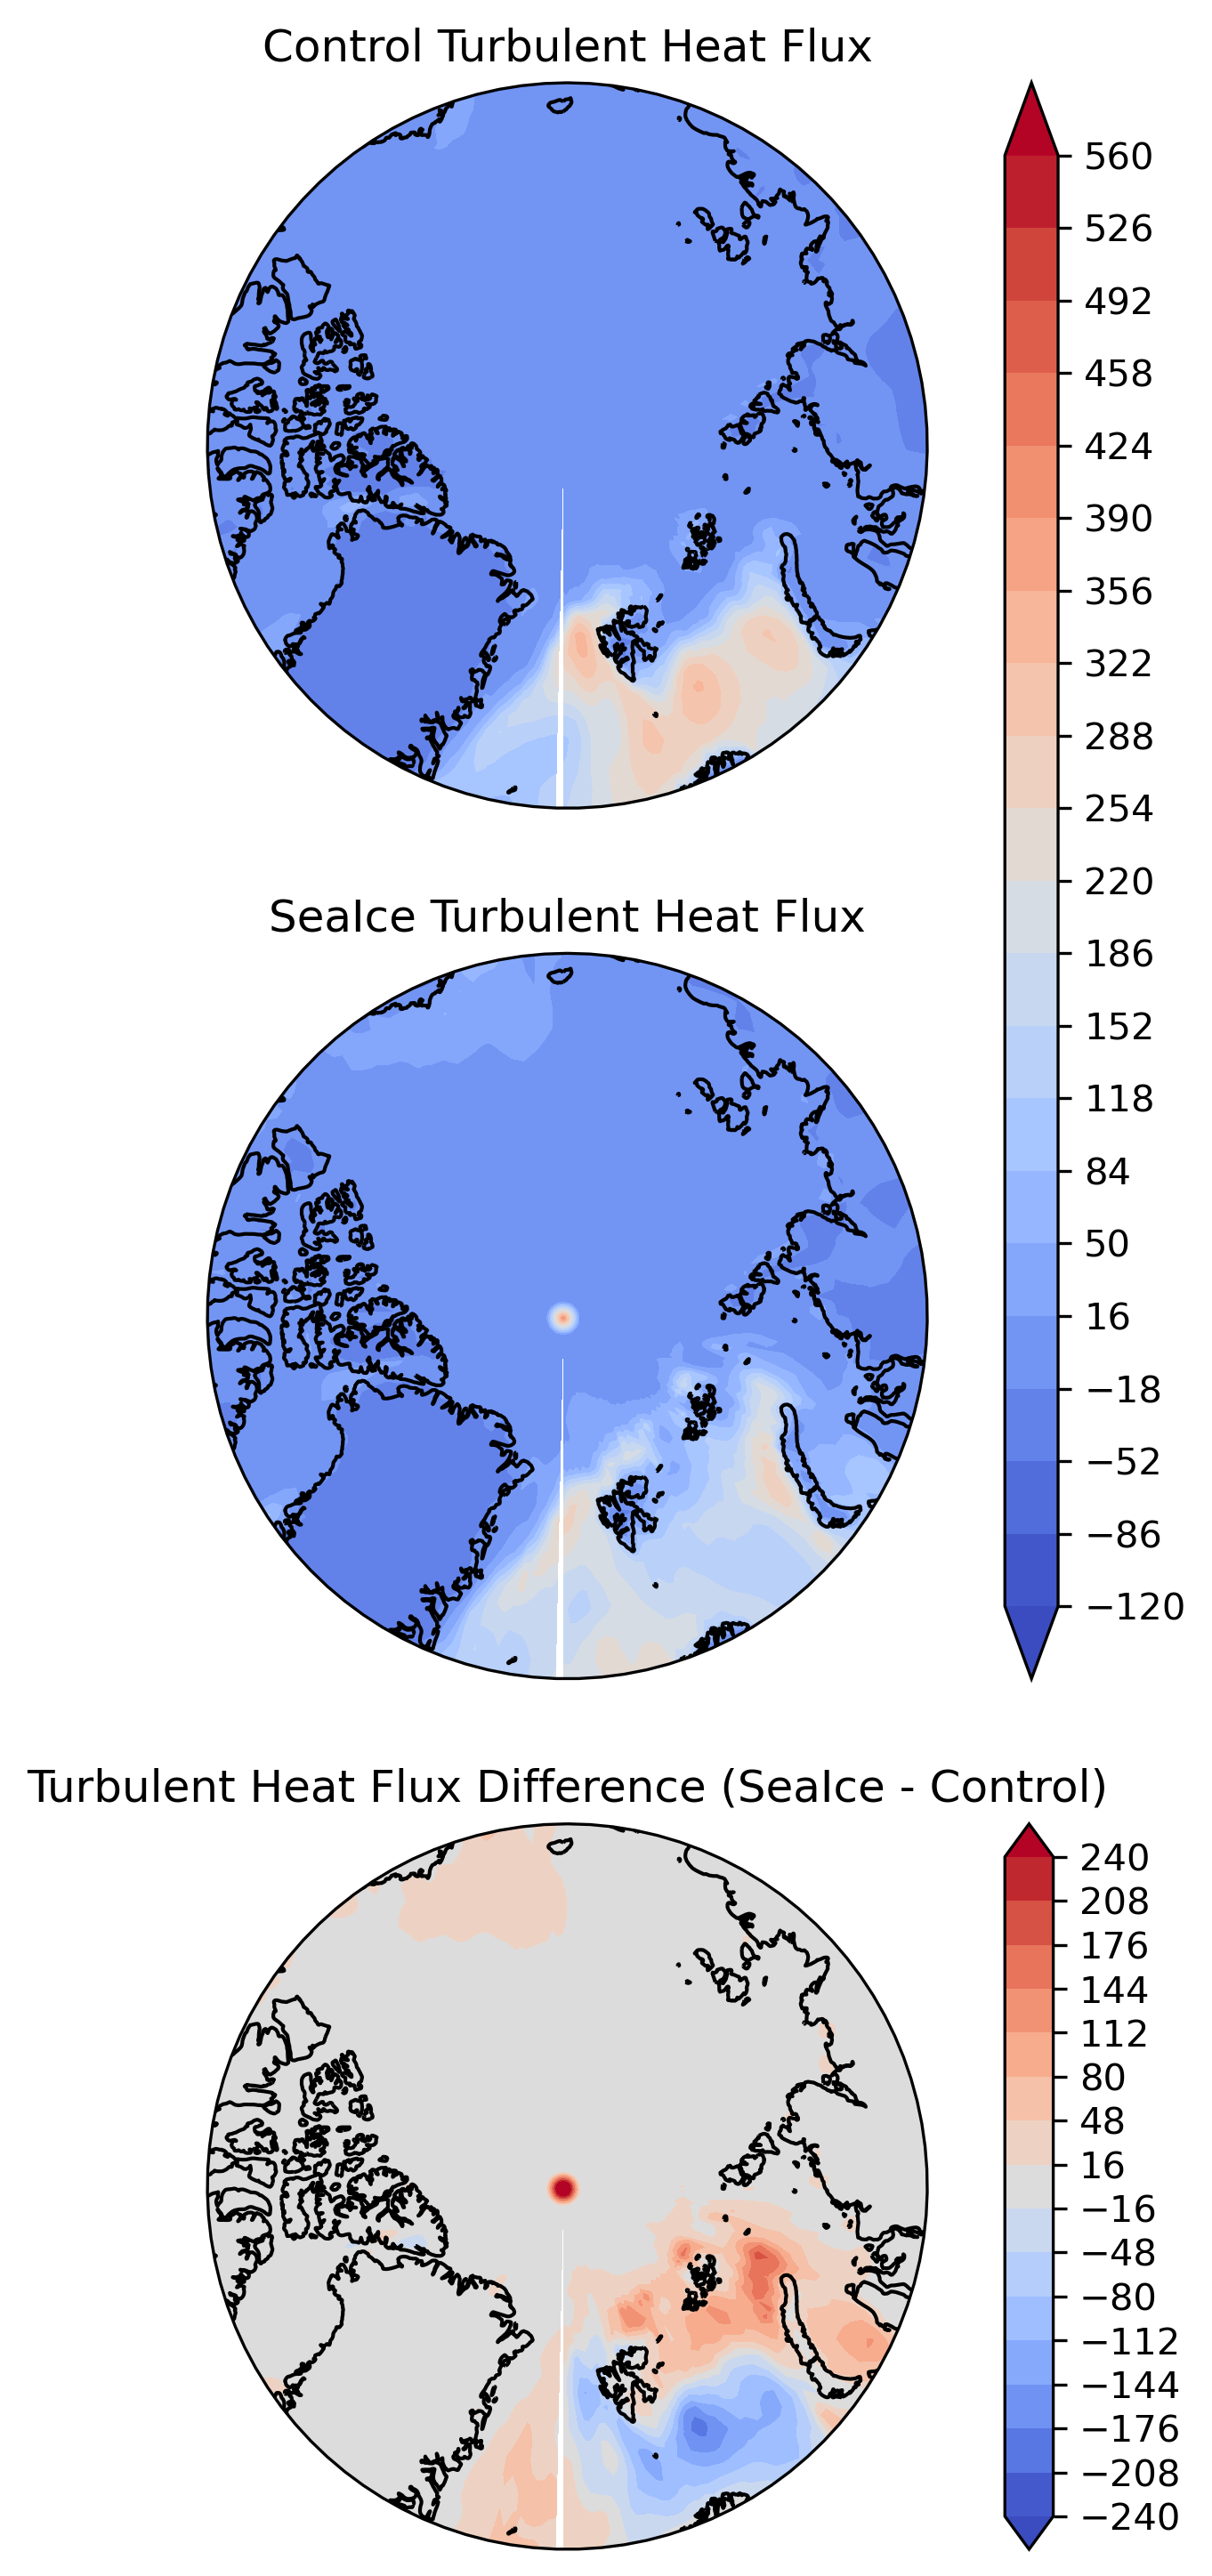

In [299]:
left_THFLX, right_THFLX, split_THFLX = -120, 560, 21
left_THFLX_diff, right_THFLX_diff, split_THFLX_diff = -240, 240, 16


CMAP = cm.coolwarm


fig, ax = plt.subplots(3, 1, figsize=(7.5, 12), dpi=300, subplot_kw={'projection': ccrs.NorthPolarStereo()})
cs1 = ax[0].contourf(ds_ctl.LON2, ds_ctl.LAT2, LHFLX_ctl+SHFLX_ctl, extend='both', levels=np.linspace(left_THFLX, right_THFLX, split_THFLX), cmap=CMAP, transform=ccrs.PlateCarree())
cs12 = ax[1].contourf(ds_ice.LON2, ds_ice.LAT2, LHFLX_ice+SHFLX_ice, extend='both', levels=np.linspace(left_THFLX, right_THFLX, split_THFLX), cmap=CMAP, transform=ccrs.PlateCarree())
fig.colorbar(cs1, ax=ax[0:2], ticks=np.linspace(left_THFLX, right_THFLX, split_THFLX), aspect=30)
ax[0].set_title("Control Turbulent Heat Flux")
ax[1].set_title("SeaIce Turbulent Heat Flux")

ax[0].add_feature(cy.feature.BORDERS)
ax[0].coastlines()
lat_lims = [70,90]
polarCentral_set_latlim(lat_lims, ax[0])


ax[1].add_feature(cy.feature.BORDERS)
ax[1].coastlines()
polarCentral_set_latlim(lat_lims, ax[1])


cs13 = ax[2].contourf(ds_ctl.LON2, ds_ctl.LAT2, LHFLX_ice+SHFLX_ice-LHFLX_ctl-SHFLX_ctl, extend='both', levels=np.linspace(left_THFLX_diff, right_THFLX_diff, split_THFLX_diff), cmap=CMAP, transform=ccrs.PlateCarree())
fig.colorbar(cs13, ticks=np.linspace(left_THFLX_diff, right_THFLX_diff, split_THFLX_diff), aspect=15)
ax[2].set_title("Turbulent Heat Flux Difference (SeaIce - Control)")

ax[2].add_feature(cy.feature.BORDERS)
ax[2].coastlines()
polarCentral_set_latlim(lat_lims, ax[2])

plt.savefig("../graphs/THFLX.png", dpi=300)
plt.show()

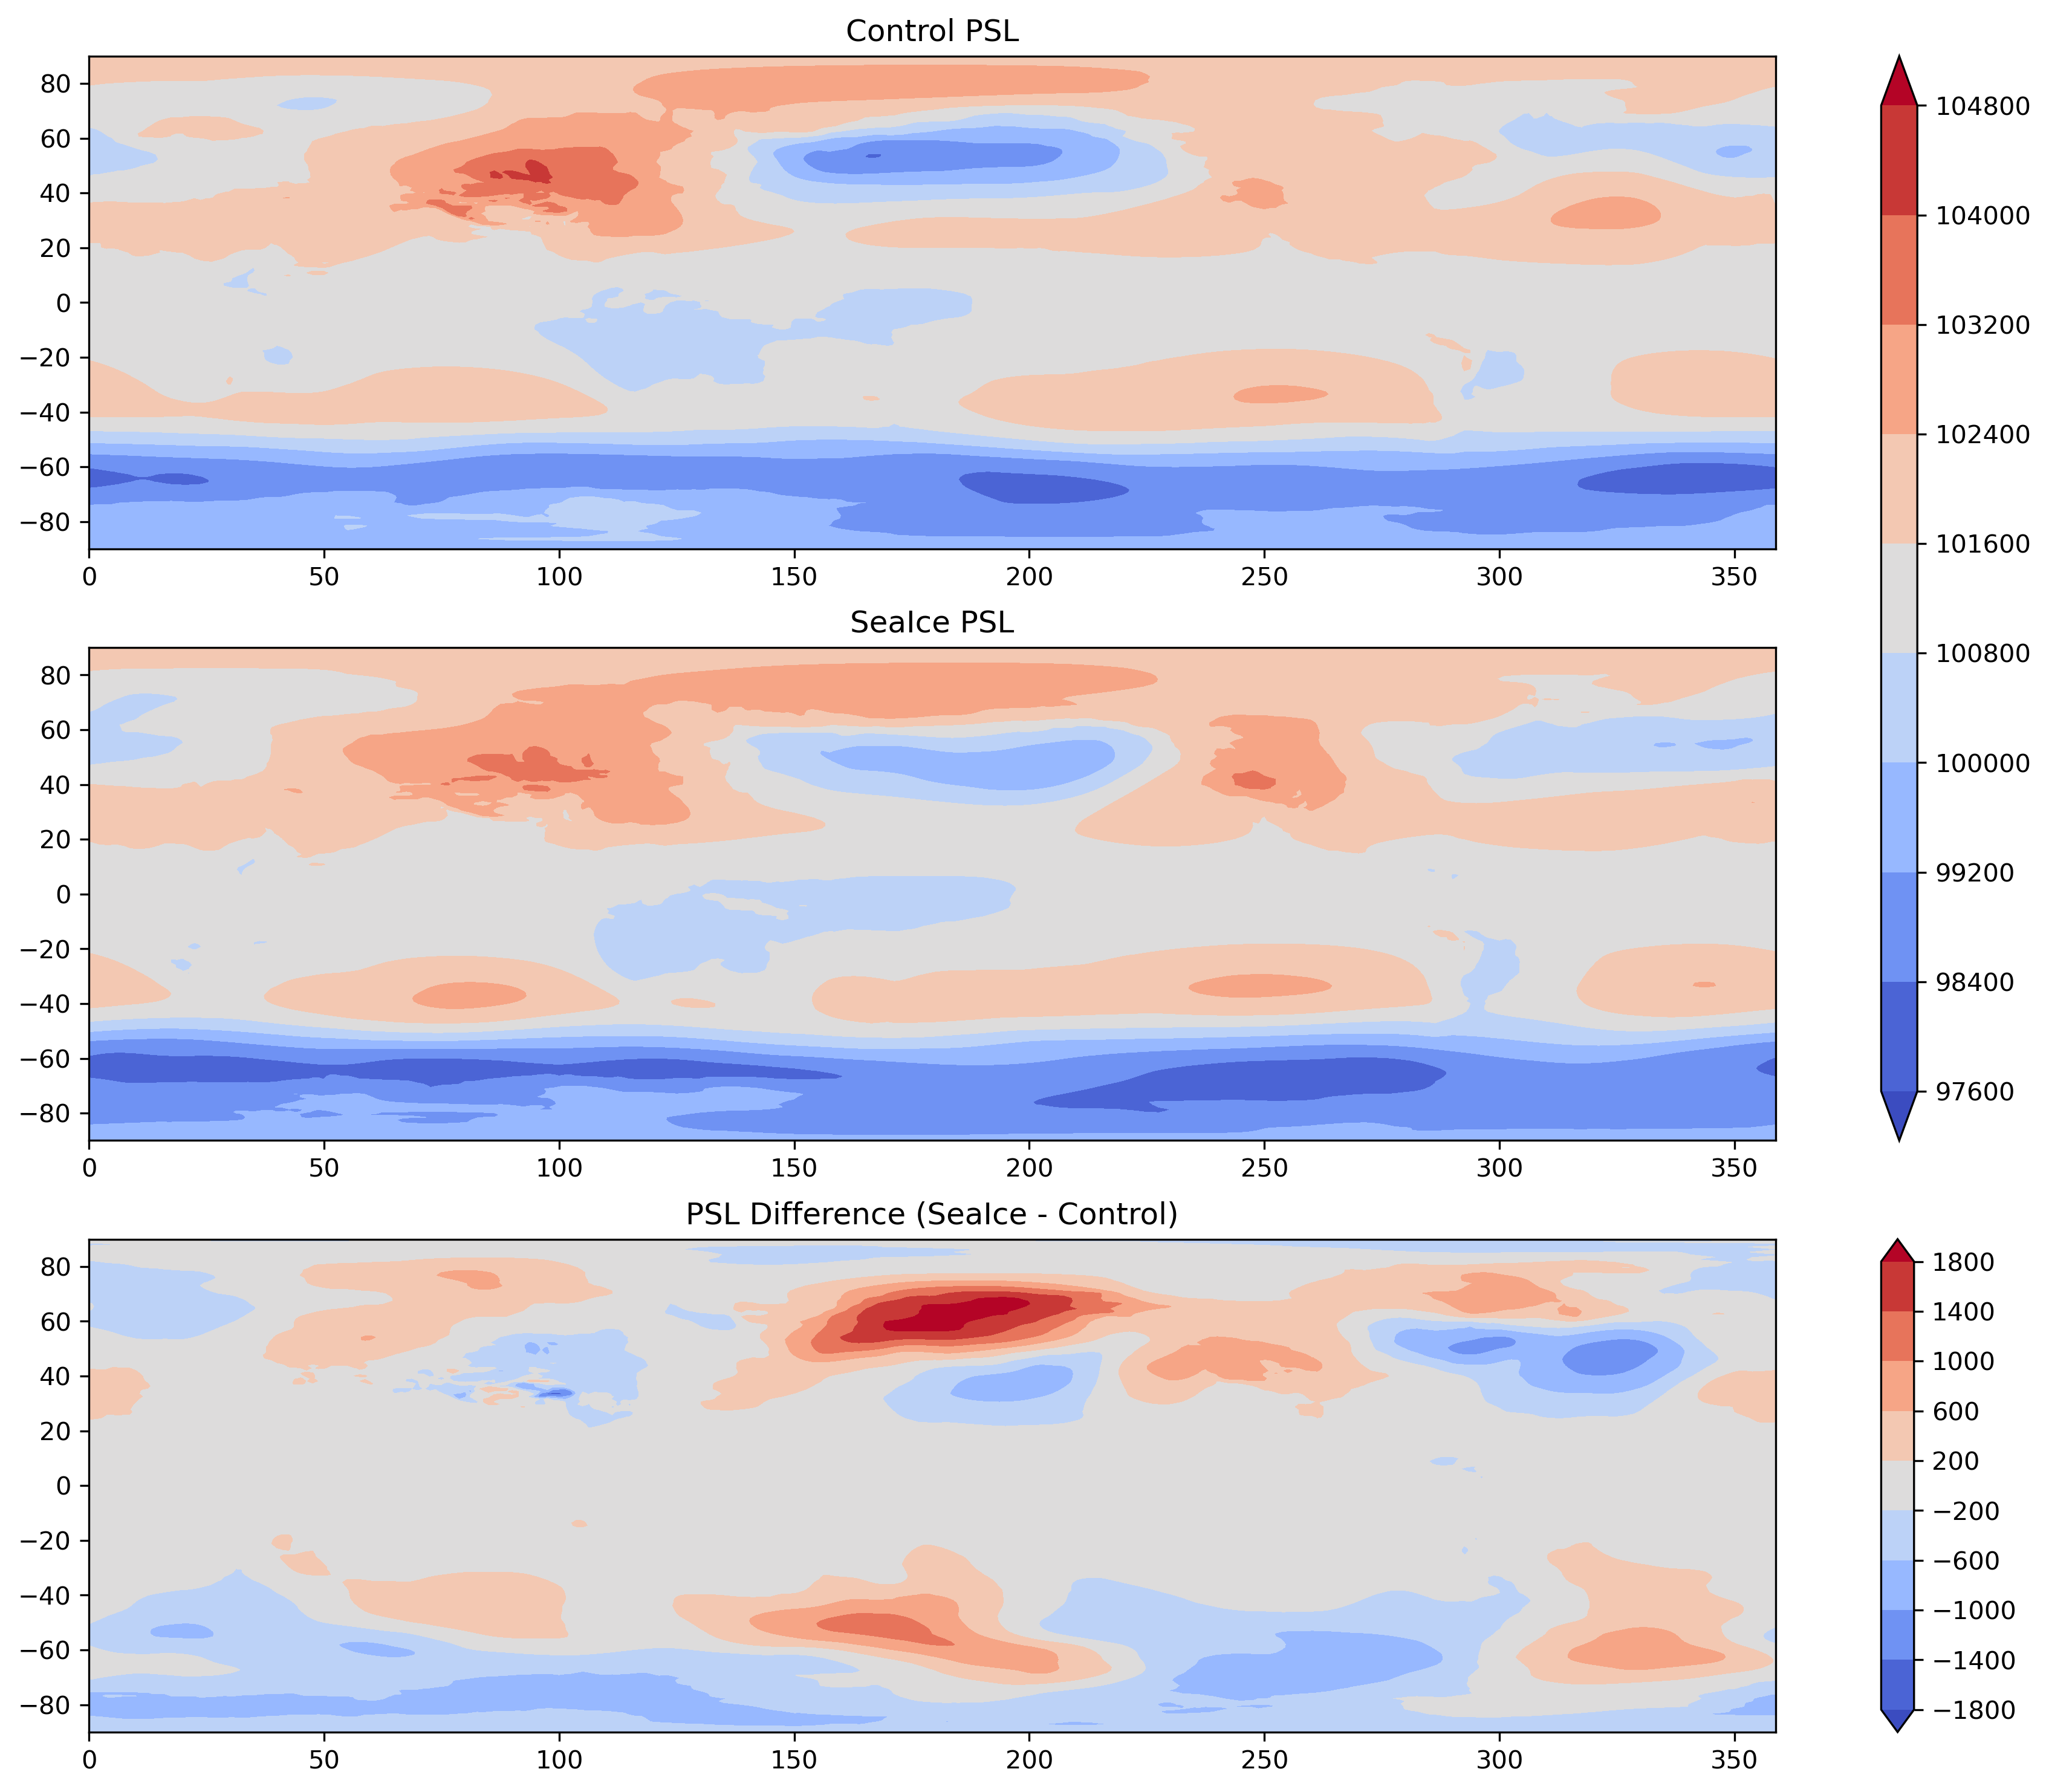

In [298]:
CMAP = cm.coolwarm

fig, ax = plt.subplots(3, 1, figsize=(15, 12), dpi=300)
cs1 = ax[0].contourf(ds_ctl.LON2, ds_ctl.LAT2, PSL_ctl, extend='both', levels=np.linspace(97600, 104800, 10), cmap=CMAP)
cs2 = ax[1].contourf(ds_ice.LON2, ds_ice.LAT2, PSL_ice, extend='both', levels=np.linspace(97600, 104800, 10), cmap=CMAP)
fig.colorbar(cs1, ax=ax[0:2], ticks=np.linspace(97600, 104800, 10), aspect=30)


ax[0].set_title("Control PSL")
ax[1].set_title("SeaIce PSL")


cs3 = ax[2].contourf(ds_ice.LON2, ds_ice.LAT2, PSL_ice-PSL_ctl, extend='both', levels=np.linspace(-1800, 1800, 10), cmap=CMAP)
fig.colorbar(cs3, aspect=15)

ax[2].set_title("PSL Difference (SeaIce - Control)")

# cb_ax1 = fig.add_axes([0.9235, 0.1, 0.015, 0.78])
# fig.colorbar(cs1, cax=cb_ax1)
plt.savefig("../graphs/PSL.png", dpi=300)

plt.show()